In [1]:
from selenium import webdriver
import os
from selenium.webdriver.common.by import By
import time
import pandas as pd
import numpy as np
from datetime import datetime
import db_multiproc_calc_neutral2 as dmc
import QuantLib as ql
import datetime as dt

rf_rate = 0.0475
slc = pd.IndexSlice

cwd = os.getcwd()

date_str = datetime.now().strftime("%Y-%m-%d")
date_str = '2023-03-23'
file_date_str = date_str

download_path = os.path.join(cwd, 'local_download', file_date_str)
file_date_str

'2023-03-23'

In [2]:
sym = 'GCJ23'
sym = 'CLK23'
sym='NGJ23'
barchart_datestr = pd.to_datetime(file_date_str).strftime('%m-%d-%Y')

In [3]:
mapOptionType = dict()
mapOptionType[1] = ql.Option.Call
mapOptionType[-1] = ql.Option.Put
mapOptionType['Call'] = ql.Option.Call
mapOptionType['Put'] = ql.Option.Put
mapOptionType['C'] = ql.Option.Call
mapOptionType['P'] = ql.Option.Put

# this is the map for aggregated expiry dates.
k_dateMap = [dt.timedelta(days=64), dt.timedelta(days=128), dt.timedelta(days=4000)]

In [4]:
def get_put_call_ratio(df_iv):
    # This takes the IV datafrmae and calcs both the delta adjusted put call and
    # natural put call ratio from the barcharts data
    df_iv = df_iv.dropna().copy()
    df_iv = df_iv.loc[:, ['strike', 'call_put', 'open_interest', 'delta']]
    df_iv['Delta-Adj-Put-Call-Ratio'] = df_iv['open_interest'] * df_iv['delta']
    df_iv = df_iv.drop(columns=['delta'])
    df_iv = df_iv.set_index(['strike', 'call_put']).groupby('call_put').sum()
    df_iv = df_iv.rename(columns={'open_interest':'Put-Call-Ratio'})
    pc_temp = df_iv.T
    return (pc_temp.loc[:,'P'] / pc_temp.loc[:,'C'])

def get_iv_data_set(sym, file_date_str, barchart_datestr):
    # compile the implied vol dataframe from the files downloaded from barcharts
    df_exp_data = pd.read_csv(os.path.join('local_download',file_date_str, f'{sym}_{file_date_str}.txt'))
    exp_date_str = df_exp_data.values[0][0]
    exp_file_date_str = pd.to_datetime(exp_date_str).strftime('%m_%d_%y')

    iv_str = df_exp_data.values[0][1]
    all_iv = pd.to_numeric(iv_str.replace('%',''))/100

    px_data_path = os.path.join('local_download', file_date_str, f'{sym}_daily_historical-data-{barchart_datestr}.csv')
    opx_data_path = os.path.join('local_download', file_date_str, f'{sym}-options-american-options-exp-{exp_file_date_str}-show-all-%futuresoptionsview%-daily-{barchart_datestr}.csv')
    gr_data_path = os.path.join('local_download', file_date_str, f'{sym}-volatility-greeks-exp-{exp_file_date_str}-show-all-{barchart_datestr}.csv')

    # read the options price data
    fpx = pd.read_csv(px_data_path, parse_dates=['Time']).dropna()
    fpx['date'] = fpx['Time'].map(lambda x:pd.to_datetime(x))
    fpx = fpx.drop(columns=['Time'])
    fpx=fpx.set_index(['date']).sort_index()
    close_px = fpx.loc[barchart_datestr, :]['Last']

    # read in the option prices and transform
    opx = pd.read_csv(opx_data_path)
    opx = opx.iloc[:-1,:]
    opx['call_put']=opx['Strike'].map(lambda x:x[-1])
    opx['num_strike']=opx['Strike'].map(lambda x:pd.to_numeric(x[:-1].replace('-','.').replace(',','')))
    opx=opx.drop(labels=['Strike', 'Delta', 'Prev Open', 'Prev High', 'Prev Low', 'Prev Change', 'Premium'], axis=1)
    opx = opx.rename(columns={'num_strike': 'Strike',
                              'Prev Volume':'Volume',
                              'Open Interest':'open_interest',
                              'Last':'mean_price'})
    opx = opx.set_index(['Strike', 'call_put'])

    # read in the greeks and transform
    gr = pd.read_csv(gr_data_path)
    gr = gr.iloc[:-1,:]

    gr['symbol']=sym
    gr['option_expiration']=pd.to_datetime(exp_date_str)
    gr['Strike']=gr['Strike'].map(lambda x:pd.to_numeric(x))
    gr['IV']=pd.to_numeric(gr['IV'].str[:-1])/100
    #gr['IV']=all_iv #RWM
    gr['Type'] = gr['Type'].map({'Put':'P', 'Call':'C'})
    gr=gr.drop(labels=['IV Skew', 'Time', 'Last'], axis=1)
    gr=gr.rename(columns={'Type':'call_put'})
    gr=gr.set_index(['Strike', 'call_put'])

    # concat and make columns lowercase
    t=pd.concat([opx, gr], axis=1)
    t['close_px'] = close_px
    t = t.reset_index()
    t.columns = map(str.lower, t.columns)

    return t

def clean_implied_vol(df_iv_file):
    x = df_iv_file.set_index(['strike', 'call_put']).sort_index().copy()
    y = x['iv'].unstack('call_put')
    idx_put_zero = y['P']==0
    idx_call_zero = y['C']==0

    idx_call_zero_replace = idx_call_zero * ~idx_put_zero
    idx_put_zero_replace = idx_put_zero * ~idx_call_zero
    y.loc[idx_call_zero_replace, 'C'] = y.loc[idx_call_zero_replace, 'P']
    y.loc[idx_put_zero_replace, 'P'] = y.loc[idx_put_zero_replace, 'C']
    y = y.rolling(3, center=True, min_periods=0).median()
    y = y.stack('call_put')
    y.name = 'clean_iv'
    x1 = pd.concat([x,y],axis=1)
    x1['iv'] = x1['clean_iv']
    x1.drop(columns='clean_iv', inplace=True)
    return x1

In [5]:
t = get_iv_data_set(sym, file_date_str, barchart_datestr)
df_iv = clean_implied_vol(t).dropna().reset_index()

query_date = barchart_datestr
root_symbol = sym

unique_strikes = sorted(t['strike'])
spot_prices = np.array(dmc.calc_spot_price_levels(unique_strikes), dtype=float)

In [6]:
target_date=query_date
calc_only_greeks=False

df_iv_file = df_iv.copy()
deltalist = []
gammalist = []

# this assumes all one trade day
trade_date = pd.Timestamp(target_date)
as_of_date = ql.Date(trade_date.day, trade_date.month, trade_date.year)
close_px = df_iv_file.close_px[0]
ql.Settings.instance().evaluationDate = as_of_date
dividend_rate = 0.0 #RWM
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(as_of_date, rf_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(as_of_date, dividend_rate, day_count)
)

In [7]:
as_of_date = ql.Date(trade_date.day, trade_date.month, trade_date.year)
idx_row=df_iv_file['option_expiration'][0]
maturity_date = ql.Date(idx_row.day, idx_row.month, idx_row.year)
exercise = ql.EuropeanExercise(maturity_date)

calc_delta = []
calc_gamma = []
for idx_row, df_row in df_iv_file.iterrows():

    # construct the European Option
    option_type = mapOptionType[df_row.call_put]
    strike = df_row.strike

    # worth 0.1 to 0.2 seconds
    payoff = ql.PlainVanillaPayoff(option_type, strike)
    european_option = ql.VanillaOption(payoff, exercise)
    spot = close_px
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))

    # worth 0.5 seconds
    volatility = df_row['iv']

    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(as_of_date, calendar, volatility, day_count)
    )

    process = ql.GeneralizedBlackScholesProcess(spot_handle,
                                                dividend_yield,
                                                flat_ts,
                                                flat_vol_ts)

    european_option.setPricingEngine(ql.AnalyticEuropeanEngine(process))#RWM
    delta = european_option.delta()
    calc_delta.append(delta)
    gamma = european_option.gamma()
    calc_gamma.append(gamma)


In [8]:
df_iv_file['calc_delta']=calc_delta
df_iv_file['calc_gamma']=calc_gamma

In [9]:
df_iv_file[['strike', 'call_put', 'open_interest', 'delta', 'calc_delta']].set_index(['strike', 'call_put'])

open_interest     delta  calc_delta
strike call_put                                     
2.00   C                  19.0  0.764336    0.747675
       P                 448.0 -0.242291   -0.229147
2.05   C                   4.0  0.661305    0.696464
       P                 362.0 -0.303783   -0.297160
2.10   C                   8.0  0.610058    0.617872
...                        ...       ...         ...
9.00   C                   0.0  0.003550    0.003597
9.50   C                   0.0  0.003443    0.003488
10.00  C                   0.0  0.003405    0.003447
11.00  C                   0.0  0.003220    0.003259
11.75  C                   0.0  0.003138    0.002680

[140 rows x 3 columns]

0.004195232359432404

0.20402208316993364

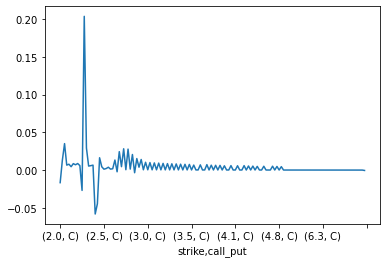

In [10]:
delta = df_iv_file[['strike', 'call_put', 'delta', 'calc_delta']].set_index(['strike', 'call_put']).diff(axis=1).iloc[:,-1]
delta.plot()
display(delta.mean(), np.abs(delta).max())

0.018092376229227408

0.7350878389331132

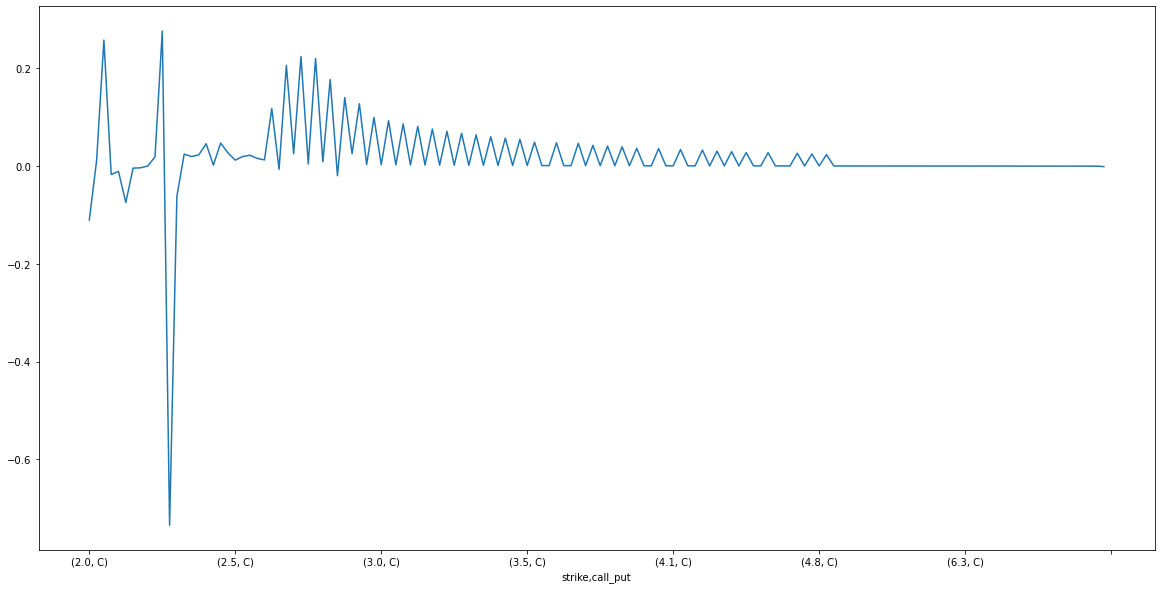

In [11]:
gamma = df_iv_file[['strike', 'call_put', 'gamma', 'calc_gamma']].set_index(['strike', 'call_put']).diff(axis=1).iloc[:,-1]
gamma.plot(figsize=(20,10))
display(gamma.mean(), np.abs(gamma).max())

In [12]:
temp = df_iv_file[['strike', 'call_put', 'gamma', 'calc_gamma']].set_index(['strike', 'call_put'])
temp

gamma  calc_gamma
strike call_put                      
2.00   C         1.309633    1.199387
       P         1.280495    1.291922
2.05   C         1.229774    1.487908
       P         1.557006    1.539976
2.10   C         1.691903    1.681132
...                   ...         ...
9.00   C         0.010149    0.010256
9.50   C         0.009574    0.009672
10.00  C         0.009196    0.009287
11.00  C         0.008323    0.008402
11.75  C         0.007863    0.006926

[140 rows x 2 columns]

In [13]:
df_iv = get_iv_data_set(sym, file_date_str, barchart_datestr)
x = df_iv.dropna().copy()
x = x.loc[:, ['strike', 'call_put', 'open_interest', 'delta']]
x['open_interest_delta'] = x['open_interest'] * x['delta']
x.set_index(['strike', 'call_put'])

open_interest     delta  open_interest_delta
strike call_put                                              
2.00   C                  19.0  0.764336            14.522380
       P                 448.0 -0.242291          -108.546498
2.05   C                   4.0  0.661305             2.645222
       P                 362.0 -0.303783          -109.969511
2.10   C                   8.0  0.610058             4.880466
...                        ...       ...                  ...
9.00   C                   0.0  0.003550             0.000000
9.50   C                   0.0  0.003443             0.000000
10.00  C                   0.0  0.003405             0.000000
11.00  C                   0.0  0.003220             0.000000
11.75  C                   0.0  0.003138             0.000000

[140 rows x 3 columns]

In [14]:
df_pcr = get_put_call_ratio(df_iv)
df_pcr

Put-Call-Ratio               0.618637
Delta-Adj-Put-Call-Ratio   -13.028553
dtype: float64